In this notebook we are going to replicate the benchmark $\Lambda$-cdm posteriors derived in `pybird/notebooks/potatoes.ipynb` to define a step-by-step sampling procedure to generate chains using PyBird's likelihoods.

In [2]:
import os, sys
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import matplotlib.pyplot as plt
import yaml

In [3]:
from classy import Class
from pybird.likelihood import Likelihood

### Configuration Files (`.yaml`)
Define a class `M()`, containing the fiducial cosmology for the EFT model. The likelihood will be computed as the probability of getting the observed data (BOSS CMASS NGC) with these parameters: $\mathcal{L} = p\left(\boldsymbol{X}|\boldsymbol{\theta}\right)$, using the selected EFT model.

In [4]:
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': 1})
M.compute()

Next, let us setup the EFT likelihood of the power spectrum multipoles of BOSS CMASS NGC.
We first load the relevant `config` file, being `pybird/data/eftboss/config`.

In [5]:
rootdir = os.path.join(os.path.expanduser('~'), 'code', 'pybird')
configdir = os.path.join(rootdir, 'data', 'eftboss', 'config')

In [6]:
config = yaml.full_load(open(os.path.join(configdir, 'boss_cmass_ngc_pk_wc.yaml'), 'r'))
config['data_path'] = os.path.join(rootdir, config['data_path'])
config['write']['out_path'] = os.path.join(rootdir, config['write']['out_path'])
print(yaml.dump(config, indent=4, sort_keys=False))

data_path: /home/errez/code/pybird/data/eftboss/
data_file: boss_dr12_2pt.npy
output: bPk
multipole: 2
with_ap: true
with_survey_mask: true
sky:
    cmass_ngc:
        min:
        - 0.01
        - 0.01
        max:
        - 0.23
        - 0.23
write:
    save: true
    fake: false
    plot: true
    show: true
    out_path: /home/errez/code/pybird/data/eftboss/out/
    out_name: boss_onesky_pk_wc
km: 0.7
kr: 0.35
nd: 0.0004
eft_basis: westcoast
with_stoch: true
eft_prior:
    b1:
        type: flat
        range: null
    c2:
        type: gauss
        mean:
        - 0.0
        range:
        - 2.0
    c4:
        type: unvaried
    b3:
        type: marg_gauss
        mean:
        - 0.0
        range:
        - 2.0
    cct:
        type: marg_gauss
        mean:
        - 0.0
        range:
        - 2.0
    cr1:
        type: marg_gauss
        mean:
        - 0.0
        range:
        - 2.0
    cr2:
        type: marg_gauss
        mean:
        - 0.0
        range:
        -

This configuration file contains all the relevant information about the data path, the output, the multipoles, the ranges (min/max) per multipoles, corrections and priors to include in the analysis.\
`pybird/data/` contains various example configuration files (`.yaml`): these files will be called by the `.data` file in the likelihood folder. For instance, you can set a Monte Python run using the `/montepython/likelihoods/eftboss` folder, connected to the `.yaml` configuration file that we have just called.

The `likelihood` notebook in the Pybird's folder then proceeds with a detailed analysis of the likelihood, maximizing it (using `iminuit`) and sampling the posteriors of the EFT parameters from it (using `emcee`).

## Monte Python Integration
As mentioned before, the actual connection between Pybird and Monte Python is the `.yaml` configuration file. To run using a Pybird preset you need to follow these steps:
1. Choose one of the configuration file (`.yaml`) from the folder `pybird/data/.../config`: here you can find presets for different priors and different data. You can copy one of them and modify it by writing directly on it or by using the script above. Customization details and motivations will be explained later.
2. Go inside the `pybird/montepython/likelihoods` folder and create your own likelihood folder<sup>[1]</sup>, named `exp_name`. As you can see, here we have already 3 likelihoods folders: the *bbn_prior* folder, used to include a BBN-motivated prior on $\omega_b$, the *eftboss* folder related to the configuration file `eftboss/config/boss_pk_wc.yaml` and the *efteboss* folder related to the configuration file `efteboss/config/eboss_pk_wc.yaml`.
3. Follow the steps described in the README of the official Pybird's documentation:
    - copy the MP-format input file `exp_name.param` found inside `pybird/montepython/input` inside the input folder in the MP workspace: `montepython/input`,
    - copy your likelihood folder to the working MP repository (`montepython/montepython/likelihoods`),
    - copy the BBN prior likelihood just as any other likelihood (you just have to do this the first time),
    - copy the data folder `data/exp_name` to your working MontePython data folder: `montepython/data`.
4. You can also add a covariance matrix to the run in order to obtain a more accurate convergence: you can find the public ones at `pybird/montepython/chains/.../exp_name.covmat` and copy them into `montepython/covmat`.
5. Run the following script using Monte Python:
    ```
    $ python montepython/MontePython.py run -p input/exp_name.param -o chains/exp_name/custom_name -c covmat/exp_name.covmat -N 5 
    ```
If everything works fine then you're ready to perform a full run, maybe using parallelization as explained in the first notebook.


<sup>[1]</sup>To create the likelihood folder, you have to include a `__init__.py` file that you can just copy from the example folders and a `exp_name.data` file containing:
- `exp_name.data_directory = 'data.path['data']'`: the same as the one inside the configuration file,
- `exp_name.config_file = 'path/to/config.yaml'`: the desired configuration file,
- `eftboss.use_nuisance = ['b1_hN', 'c2_hN', 'b1_hS', 'c2_hS', 'b1_lN', 'c2_lN', 'b1_lS', 'c2_lS']`: nuisance parameters for the posterior sampling: these will be displayed in the output `log.param` file.


### First Run ($5$ steps) - EftBoss on $P_\mathcal{l}(k)$ using WC prior
After completing the process described previously, I launched the test run as: 
<center>

`python montepython/MontePython.py run -p input/eftboss.param -o chains/eftboss/lcdm_wc -c covmat/cdm_eftboss_wc.covmat`
</center>

adding `-N 5` to compute only 5 steps.\
No errors, acceptance rate $r=0.6$. The chain is stored here, inside the `chains` folder. Does GetDist recognize it?

In [7]:
# Define chain folder
chain_dir = os.path.join(os.getcwd(), 'chains')
chain_dir

'/home/errez/code/montepython_tutorial/chains'

In [8]:
# Load the samples using GetDist: attention to the complete name of the chain!
from getdist import loadMCSamples, plots, mcsamples, MCSamples
samples = loadMCSamples(file_root=chain_dir+'/eftboss/lcdm_wc/2023-09-25_5_', settings={'ignore_rows':0})

/home/errez/code/montepython_tutorial/chains/eftboss/lcdm_wc/2023-09-25_5__1.txt
Removed no burn in


__*First question*__: GetDist takes derived parameters as running ones. Is it correct? Is it just a matter of notation but the behavior is the same? Perhaps I could try to remove the derived parameters from the configuration file and the covariance matrix and use GetDist's `AddDerived()` method.\
I noticed that the covariance matrix does not contains values for $A_s$ and $\sigma_8$.

In [9]:
print('Running parameters: ', np.transpose(samples.getParamNames().getRunningNames()))
print('Derived parameters: ', np.transpose(samples.getParamNames().getDerivedNames()))
par_names = samples.getParamNames().list()

Running parameters:  ['omega_b' 'omega_cdm' 'h' 'ln10^{10}A_s' 'n_s' 'b1_hN' 'c2_hN' 'b1_hS'
 'c2_hS' 'b1_lN' 'c2_lN' 'b1_lS' 'c2_lS' 'Omega_m' 'A_s' 'sigma8']
Derived parameters:  []


__*Second Question*__: trying to plot the current sampled posterior will output a *IndexError* error. It is possible that this error is due to the limited size of the sample?

In [10]:
cosmo = np.array(['Omega_m', 'h', 'sigma8'])
g = plots.get_subplot_plotter()

# Compiling the following line will raise an error
# g.triangle_plot([samples], cosmo, filled=True)

Below, further info about the MC samples.

<Axes: >

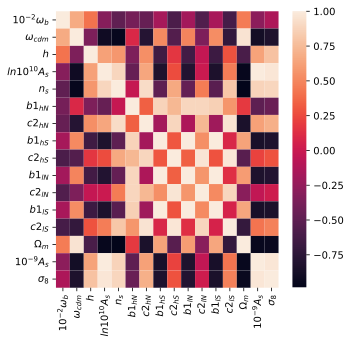

In [11]:
# Correlation matrix
import seaborn as sns

fig, ax = plt.subplots(figsize=(5,5)) # Sample figsize in inches
# Define list of parameter labels for plotting
par_labels = [f'${samples.parLabel(i)}$' for i in range(len(par_names))]
sns.heatmap(samples.corr(), annot=False, ax=ax, xticklabels=par_labels, yticklabels=par_labels)

In [12]:
# Parameter means
samples.getMeans()

array([ 2.2472968 ,  0.12062296,  0.6800764 ,  3.0117254 ,  0.92853862,
        1.9714206 , -0.2387004 ,  1.998564  , -0.03356483,  1.9968148 ,
       -0.02681262,  2.0043146 , -0.01496916,  0.31097854,  2.0433428 ,
        0.78985908])

In [13]:
# Parameter variances
samples.getVars()

array([6.42588193e-04, 4.84675613e-05, 4.60978241e-05, 1.07389939e-02,
       6.10324005e-03, 3.71740989e-03, 5.55029168e-02, 4.05158704e-03,
       3.79626892e-03, 3.28953751e-03, 2.93667263e-03, 2.84715362e-03,
       2.09742596e-03, 3.38053269e-04, 4.68374371e-02, 1.48949924e-03])

In [14]:
# Updated covariance matrix
samples.getCov()

array([[ 6.42588193e-04,  1.18801087e-04,  7.17875004e-05,
        -8.34736361e-04, -9.84772228e-04, -6.02501492e-04,
        -2.78432694e-03, -2.70682645e-04, -9.23057830e-04,
        -2.70640818e-04, -7.76532542e-04, -2.15717950e-04,
        -7.21093544e-04,  2.10813289e-04, -1.54490708e-03,
        -1.36982496e-04],
       [ 1.18801087e-04,  4.84675613e-05, -1.68204678e-05,
        -6.51810987e-04, -5.16482982e-04,  4.15864953e-05,
        -1.29990101e-03,  2.29168678e-04, -2.39160081e-04,
         1.95015529e-04, -1.32189798e-04,  1.97500682e-04,
        -2.28962922e-04,  1.22862588e-04, -1.33221231e-03,
        -2.22016081e-04],
       [ 7.17875004e-05, -1.68204678e-05,  4.60978241e-05,
         4.36404090e-04,  3.07952856e-04, -1.46787849e-04,
         8.61322151e-04, -2.84843491e-04,  6.93641548e-05,
        -2.48816904e-04, -1.13720344e-05, -2.43259718e-04,
         8.87714496e-05, -7.53293758e-05,  9.31931041e-04,
         2.06481944e-04],
       [-8.34736361e-04, -6.51810987e

In [15]:
# Best-fit values not found: we have to include a specific .minimum or .best-fit file
# samples.getBestFit(max_posterior=True)

### Second Run ($200$ steps) - EftBoss on $P_\mathcal{l}(k)$ using WC prior
Repeat everything as before, but this time let the sampling run for 200 steps.

In [16]:
# Load the samples using GetDist: attention to the complete name of the chain!
from getdist import loadMCSamples, plots, mcsamples, MCSamples
samples = loadMCSamples(file_root=chain_dir+'/eftboss/lcdm_wc/2023-09-25_200_', settings={'ignore_rows':0})

/home/errez/code/montepython_tutorial/chains/eftboss/lcdm_wc/2023-09-25_200__1.txt
Removed no burn in


In [17]:
cosmo = np.array(['Omega_m', 'h', 'sigma8'])
g = plots.get_subplot_plotter()

# Compiling the following line will still raise an error: not enough samples!
# g.triangle_plot([samples], cosmo, filled=True)

### Third Run ($2000$ steps) - EftBoss on $P_\mathcal{l}(k)$ using WC prior
Repeat everything as before, but this time let the sampling run for 2000 steps.

In [18]:
# Load the samples using GetDist: attention to the complete name of the chain!
from getdist import loadMCSamples, plots, mcsamples, MCSamples
samples = loadMCSamples(file_root=chain_dir+'/eftboss/lcdm_wc/2023-09-25_2000_', settings={'ignore_rows':0})

In [19]:
# Also here the derived parameters are not recognised as such
print('Running parameters: ', np.transpose(samples.getParamNames().getRunningNames()))
print('Derived parameters: ', np.transpose(samples.getParamNames().getDerivedNames()))
par_names = samples.getParamNames().list()

Running parameters:  ['omega_b' 'omega_cdm' 'h' 'ln10^{10}A_s' 'n_s' 'b1_hN' 'c2_hN' 'b1_hS'
 'c2_hS' 'b1_lN' 'c2_lN' 'b1_lS' 'c2_lS' 'Omega_m' 'A_s' 'sigma8']
Derived parameters:  []


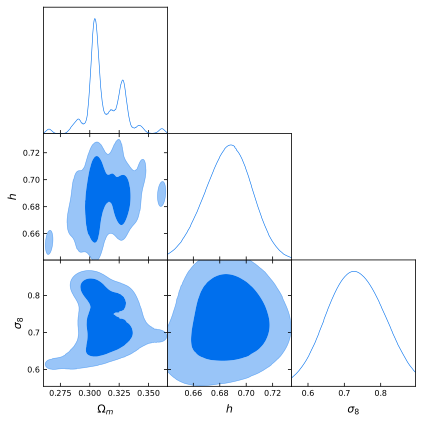

In [20]:
cosmo = np.array(['Omega_m', 'h', 'sigma8'])
g = plots.get_subplot_plotter()

# Compiling the following line will still raise an error: not enough samples!
g.triangle_plot([samples], cosmo, filled=True)

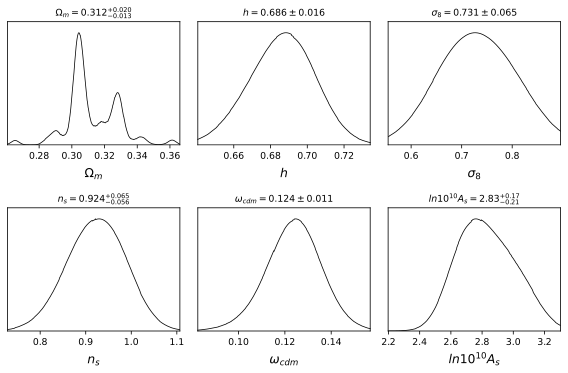

In [21]:
cosmo = ['Omega_m', 'h', 'sigma8', 'n_s', 'omega_cdm', 'ln10^{10}A_s']
g = plots.get_subplot_plotter(width_inch=8) 
g.plots_1d([samples], cosmo, filled=True, title_limit=1, nx=3)
plt.show()

In [22]:
# The means are NOT the one printed on top of each 1-D posterior plot
for i in range(len(cosmo)):
    # Print only the means of 'cosmo' parameters
    print(cosmo[i], f' = {samples.getMeans(pars=np.where(np.in1d(par_names, cosmo))[0])[i]:0.3f}')

Omega_m  = 0.124
h  = 0.686
sigma8  = 2.826
n_s  = 0.924
omega_cdm  = 0.312
ln10^{10}A_s  = 0.731


__*First question*__: what are the values printed above the plots and produced by `samples.getInlineLatex()`? They are not (always) the mean values, and they are not even the best-fit parameters (max-likelihood). I suppose they are MAP values but I could not find any hint, since GetDist refers to MAP values as the ones stored inside the `.minimum` file.

In [23]:
# These are the actual values printed in the plot above
for param in cosmo:
    print(samples.getInlineLatex(param=param, limit=1, err_sig_figs=None))

\Omega{}_{m } = 0.312^{+0.020}_{-0.013}
h = 0.686\pm 0.016
\sigma_8 = 0.731\pm 0.065
n_{s } = 0.924^{+0.065}_{-0.056}
\omega{}_{cdm } = 0.124\pm 0.011
ln10^{10}A_{s } = 2.83^{+0.17}_{-0.21}


In [25]:
print(samples.getLikeStats())

Best fit sample -log(Like) = 88.828000
mean(-Ln(like)) = 95.772484
-Ln(mean like)  = 91.546632

parameter      bestfit        lower1         upper1         lower2         upper2
omega_b        2.2910190E+00  2.3449710E+00  0.0000000E+00  2.3449710E+00  2.0000000E-02   10^{-2}\omega{}_{b }
omega_cdm      1.2517020E-01  1.4899420E-01 4.6750917E-310  1.4899420E-01  0.0000000E+00   \omega{}_{cdm }
h              6.8458490E-01  7.2143900E-01 6.9100076E-310  7.2143900E-01 4.6741107E-310   h
ln10^{10}A_s   2.9647320E+00  3.1697520E+00 4.6751063E-310  3.1697520E+00  0.0000000E+00   ln10^{10}A_{s }
n_s            8.7679330E-01  1.0329000E+00 6.9100076E-310  1.0329000E+00 4.6740575E-310   n_{s }
b1_hN          1.8674480E+00  2.4790090E+00 4.6751480E-310  2.7014460E+00  0.0000000E+00   b1_{hN }
c2_hN         -7.2058100E-02  2.1673330E+00 6.9100076E-310  2.3064910E+00 4.6740645E-310   c2_{hN }
b1_hS          2.0692580E+00  2.5585500E+00 1.1411290E-313  2.7124870E+00  0.0000000E+00   b1_{hS }
c2_hS

### Fourth Run ($2000$ steps) - EftBoss on $P_\mathcal{l}(k)$ using WC prior without BBN prior
Repeat everything as before, but this time excluding the BBN prior. For this exercise, I changed the `.param` file, eliminating the second dataset named `bbn_prior`, as well as commenting the line `data.cosmo_arguments['sBBN file']=...` since it refers to the BBN dataset.\
\
The script to launch the sampling with will be:
<center>

`python montepython/MontePython.py run -p input/eftboss_no_bbn.param -o chains/eftboss/lcdm_no_bbn -c covmat/cdm_eftboss_wc.covmat -N 2000`
</center>

where I left the same covariance matrix as before.


In [198]:
# Load the samples using GetDist: attention to the complete name of the chain!
# We also remove the first 30% of the chain to avoid non-markovian points
boss = loadMCSamples(file_root=chain_dir+'/eftboss/lcdm_wc/2023-09-25_2000_', settings={'ignore_rows':0.3})
boss_no_bbn = loadMCSamples(file_root=chain_dir+'/eftboss/lcdm_no_bbn/2023-09-25_2000_', settings={'ignore_rows':0.3})

/home/errez/code/montepython_tutorial/chains/eftboss/lcdm_no_bbn/2023-09-25_2000__2.txt
/home/errez/code/montepython_tutorial/chains/eftboss/lcdm_no_bbn/2023-09-25_2000__1.txt
Removed 0.3 as burn in


In [199]:
# Change name for plotting purposes
boss.name_tag = 'BOSS + BBN'
boss_no_bbn.name_tag = 'BOSS'

In [200]:
cosmo = ['Omega_m', 'h', 'sigma8', 'n_s', 'omega_cdm', 'ln10^{10}A_s']
g = plots.get_subplot_plotter(width_inch=10)
g.triangle_plot([boss, boss_no_bbn], cosmo, filled=True)

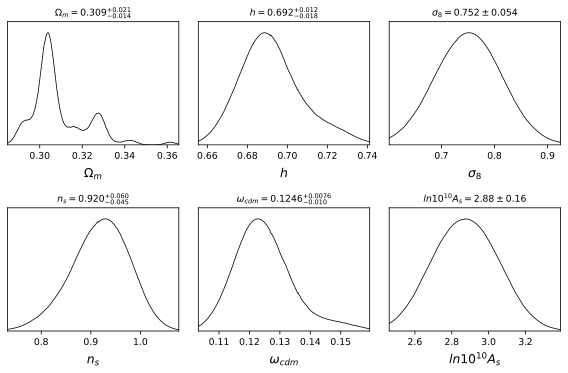

In [201]:
# Plotting 1D distribution with MAP values on top
cosmo = ['Omega_m', 'h', 'sigma8', 'n_s', 'omega_cdm', 'ln10^{10}A_s']
g = plots.get_subplot_plotter(width_inch=8) 
g.plots_1d([boss_no_bbn], cosmo, filled=True, title_limit=1, nx=3)
plt.show()